In [1]:
%load_ext autoreload
%autoreload

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import re
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, TensorBoard
from keras import metrics
import json
from helper_functions import import_data, neuralnet_model, batch_generator
from sklearn.metrics import confusion_matrix
from os import listdir
import seaborn as sn

Using TensorFlow backend.


In [2]:
X_test, y_test = import_data('jsons_test/' + listdir('jsons_test')[0])

In [15]:
X_test.nbytes

566942712

In [29]:
np.float64(1).nbytes * 80000 / 1000000 * 250

160.0

In [38]:
def import_data(json_directory, num_rows):
    """
    Parameter: String
    Output: 2 Numpy arrays
    
    Reads json from path 'json_path' that has multiple rows of dense matrix and a star rating.
    Processes the file, creates a dense matrix.
    Returns the dense matrix and star rating matrix
    """

    count_vec_list_positive = []
    count_vec_list_negative = []
    num_positive, num_negative, file_count = 0, 0, 0
    json_paths = listdir(json_directory)
    path_shuffle = np.arange(len(json_paths))
    np.random.shuffle(path_shuffle)

    while 1:
        
        vocab_size_saved = False
        with open(json_directory + '/' + json_paths[path_shuffle[file_count]], 'r') as f:
            for line in f:
                #creates separate lists for sparse vec data, and star review
                if json.loads(line)['star_rating'] == 1:
                    count_vec_list_positive.append(json.loads(line)['count_vec'])
                else:
                    count_vec_list_negative.append(json.loads(line)['count_vec'])

                #Tracks how many positive/negative reviews have been seen
                if json.loads(line)['star_rating'] == 1:
                    num_positive += 1
                else:
                    num_negative += 1

                #Saves the vocab size on the first pass
                if not vocab_size_saved:
                    num_matrix_columns = json.loads(line)['count_vec']['size']
                    vocab_size_saved = True

                #Builds dense matrix if we have gathered enough of each rating
                if num_positive >= num_rows / 2 and num_negative >= num_rows / 2:
                    num_positive, num_negative = 0, 0
                    #creates an empty matrix of the size to fit the read in data
                    #adds an extra column to hold positive/negative value
                    dense_matrix = np.zeros([num_rows, num_matrix_columns + 1])          

                    #loops through positive reviews to create dense matrix
                    for i, row in enumerate(count_vec_list_positive):
                        indices = row['indices']
                        values = row['values']

                        #Replaces the indices of row i in the dense_matrix with the values
                        np.put(dense_matrix[i, :], indices, values)

                        #sets last column to indicate positive
                        dense_matrix[i, -1] = 1

                    #loops through negative reviews to create dense matrix
                    for i, row in enumerate(count_vec_list_positive):
                        indices = row['indices']
                        values = row['values']

                        #Replaces the indices of row i in the dense_matrix with the values
                        np.put(dense_matrix[i + (num_rows / 2), :], indices, values)

                        #sets last column to indicate negative
                        dense_matrix[i + (num_rows / 2), -1] = 0
                    
                    #Creates an array of randomized indexs with lengh equal to number of dense_matrix rows
                    shuffle_dense_indexs = np.arange(dense_matrix.shape[0])
                    np.random.shuffle(shuffle_dense_indexs)
                    
                    dense_matrix = dense_matrix[shuffle_dense_indexs]

                    #Declares the lists as empty
                    count_vec_list_positive = []
                    count_vec_list_negative = []

                    yield dense_matrix[:, :-1], dense_matrix[:, ]

            #Tracks the number of files used, and reshuffles the indexes if we have used all the files in the list
            file_count += 1
            if file_count == len(json_paths):
                file_count = 0
                np.random.shuffle(path_shuffle)

In [39]:
for X_, y_ in import_data('jsons_full', 250):
    X = X_
    y = y_
    break

KeyboardInterrupt: 

In [31]:
X_test[0, -1] = 1
X_test[0, -1]

1.0

In [10]:
batch_size = 2000
nb_epoch = 10
samples_per_epoch = 15

for x_, y_ in batch_generator('json_test', batch_size, samples_per_epoch):
    X_debug = x_
    y_debug = y_
    break

In [11]:
y_debug

array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [12]:
autoencoder_model_created = False
model_path = 'models/basic_autoencoder1.h5'

if not autoencoder_model_created:
    model = neuralnet_model(X_test)

    batch_size = 2000
    nb_epoch = 10
    samples_per_epoch = 15

    # instantiate callbacks
    tensorboard = TensorBoard(log_dir='./autoencoder_logs', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True)
    earlystopping = EarlyStopping(monitor='val_loss', patience=2)

    # try different number of epochs - 10 gives good performanace 
    """model.fit(X_train, X_train, epochs=10, batch_size=batch_size, verbose=1,
              validation_split=0.1, callbacks = [earlystopping, tensorboard])""" # cross val to estimate test error


    model.fit_generator(generator=batch_generator('jsons_full', batch_size, samples_per_epoch),
                        epochs=nb_epoch,
                        steps_per_epoch=samples_per_epoch)


    scores = model.evaluate(X_test, y_test)
    print('Test mse = {}'.format(scores[0]))

    y_predictions = model.predict(X_test)
    
    model.save(model_path)

else:
    model = load_model(model_path)
    scores = model.evaluate(X_test, X_test)
    print('Test mse = {}'.format(scores[0]))


Epoch 1/10
15/15 [==============================] - 7s 455ms/step - loss: 1.3021 - acc: 0.5027
Epoch 2/10
15/15 [==============================] - 7s 448ms/step - loss: 0.7283 - acc: 0.5594
Epoch 3/10
15/15 [==============================] - 7s 443ms/step - loss: 0.4103 - acc: 0.8506
Epoch 4/10
15/15 [==============================] - 7s 451ms/step - loss: 0.2721 - acc: 0.9019
Epoch 5/10
15/15 [==============================] - 7s 442ms/step - loss: 0.2565 - acc: 0.8970
Epoch 6/10
15/15 [==============================] - 7s 451ms/step - loss: 0.2454 - acc: 0.9012
Epoch 7/10
15/15 [==============================] - 7s 441ms/step - loss: 0.2167 - acc: 0.9155
Epoch 8/10
15/15 [==============================] - 7s 451ms/step - loss: 0.2237 - acc: 0.9116
Epoch 9/10
15/15 [==============================] - 7s 442ms/step - loss: 0.2307 - acc: 0.9091
Epoch 10/10
4683/4683 [==============================] - 1s 168us/step
Test mse = 0.2577980881556471


In [45]:
confusions = confusion_matrix(y_test, y_predictions < 0.5)

In [46]:
confusions

array([[  32,  535],
       [3669,  447]])

In [48]:
true_negative = confusions[0,0]
false_positive = confusions[0,1]
false_negative = confusions[1, 0]
true_positive = confusions[1, 1]

In [49]:
print('Recall: {:0.2f}'.format(true_positive / (true_positive + false_negative)))
print('Precision: {:0.2f}'.format(true_positive / (true_positive + false_positive)))

Recall: 0.11
Precision: 0.46


In [39]:
conf_df = pd.DataFrame([[true_positive, false_positive], [false_negative, true_negative]], \
                       ['predicted positive', 'predicted negative'], \
                       ['condition positive', 'condition negative'])
conf_df

,condition positive,condition negative
predicted positive,3669,32
predicted negative,447,535


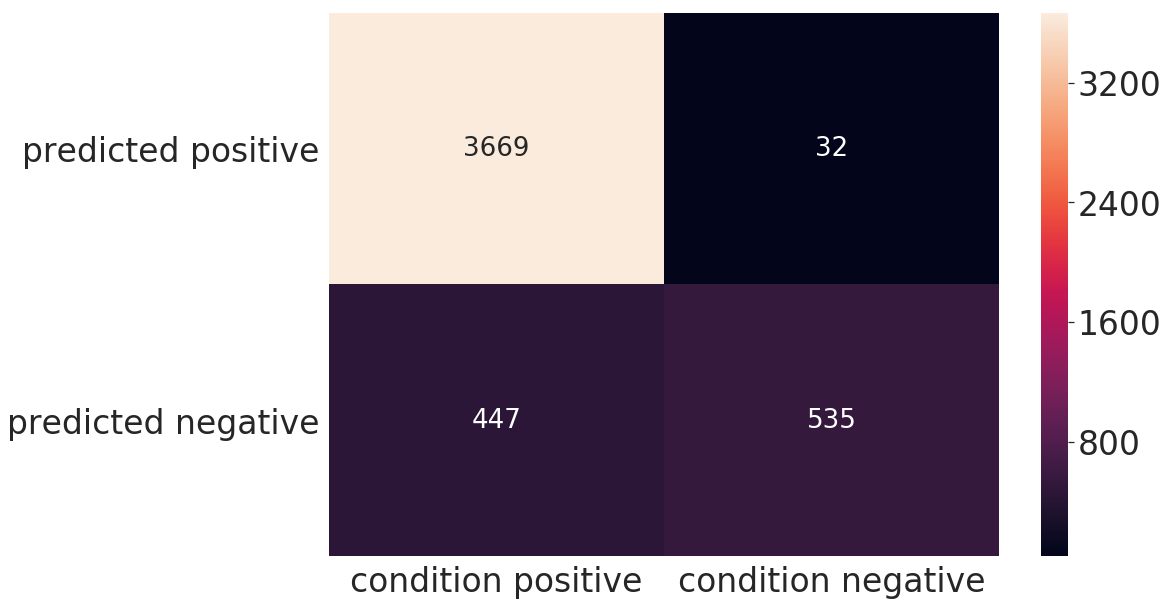

In [41]:
plt.figure(figsize=(15,10))
sn.set(font_scale=3)
sn.heatmap(conf_df, annot=True, annot_kws={'size': 26}, fmt='g')

In [ ]:
X_test_decoded[X_test_decoded < 0.5].shape

In [ ]:
X_test_decoded[X_test_decoded < 0.5].shape

In [ ]:
X_test_decoded[X_test_decoded < 0.5].shape

In [ ]:
X_test_decoded[X_test_decoded < 0.5].shape

In [16]:
y_test.shape

(4683,)

In [18]:
y_test[y_test == 1].shape

(4116,)

In [19]:
X_test_decoded

array([[0.999895  ],
       [0.9999863 ],
       [0.99558365],
       ...,
       [0.9860421 ],
       [0.9999702 ],
       [0.99895084]], dtype=float32)